### Importing Libraries

In [ ]:
!pip install nltk #Natural Language Toolkit
!pip install demoji #Used for converting emojis into text.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 744.0 kB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import demoji
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Logistic Regression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

### Importing Dataset

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Project 1/Dataset/cyberbullying_tweets.csv')

### Exploratory Data Analysis

In [ ]:
dataset.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [ ]:
dataset.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [ ]:
#There are no null values in the dataset

In [ ]:
dataset.shape

(47692, 2)

In [ ]:
dataset.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


In [ ]:
dataset.columns

Index(['tweet_text', 'cyberbullying_type'], dtype='object')

In [ ]:
dataset['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

In [ ]:
#The cyberbullying_type is equally split as we can see from the above data.

In [ ]:
dataset.duplicated().sum()

36

In [ ]:
dataset.drop_duplicates(subset='tweet_text',keep='first',inplace=True)

In [ ]:
dataset.shape

(46017, 2)

### Encoding cyberbullying_type in the dataset

In [ ]:
ENCODE_DICT = {'not_cyberbullying': 0,
             'gender': 1,
             'religion': 2,
             'other_cyberbullying': 3,
             'age': 4,
             'ethnicity': 5}
dataset['cyberbullying_type'] = dataset.cyberbullying_type.replace(ENCODE_DICT)
print(dataset.cyberbullying_type.unique())

[0 1 2 3 4 5]


In [ ]:
dataset.sample(5)

,tweet_text,cyberbullying_type
41148,@crvtmin — first impression: ion remember — yo...,5
8977,Who's going to be the feminazi of Northmor whe...,1
40424,so the black guy is racist because he got offe...,5
4767,"@anggarasuwahju oits... Siapp, blm lengkap. Ha...",0
22807,@SirajZarook @OdiniaInvictus @BilalIGhumman @I...,2


### Data Cleaning

In [ ]:
def cleantext(text):

  #Removal of hashtags, mentions, urls and retweets
  pattern = re.compile(r"(#[A-Za-z0-9]+|@[A-Za-z0-9]+|https?://\S+|www\.\S+|\S+\.[a-z]+|RT @)")
  text = pattern.sub('', text)

  #Removal of multiple spaces between words and rejoining using single space
  text = " ".join(text.split())

  #Lemmatize each word in the tweet
  #Lemmatization is the process of reducing words to their base or dictionary form, called the lemma.
  lemma = WordNetLemmatizer()
  text = " ".join([lemma.lemmatize(word) for word in text.split()])

  #Instead of removing the emoji, we convert the emoji in the tweet to text and add it back to the tweet
  emoji = demoji.findall(text)
  for emot in emoji:
      text = re.sub(r"(%s)" % (emot), "_".join(emoji[emot].split()), text)

  #Expansion of contractions
  contractions = {
        r"can\'t": "can not",
        r"n\'t": " not",
        r"\'re": " are",
        r"\'s": " is",
        r"\'d": " would",
        r"\'ll": " will",
        r"\'ve": " have",
        r"\'m": " am"
    }
  for contraction, expansion in contractions.items():
        text = re.sub(contraction, expansion, text)

  #Stopwords are commonly used words (e.g., "a", "the", "is") that do not carry significant meaning. Thus stopwords are removed.
  STOPWORDS = set(stopwords.words('english'))
  text = " ".join([word for word in str(text).split() if word not in STOPWORDS])

  #Remove special characters keep only text
  text = re.sub(r'[^a-zA-Z\s]', '', text)

  return text

In [ ]:
dataset['cleaned_tweet_text'] = dataset.tweet_text.apply(lambda text: cleantext(text))

In [ ]:
dataset.sample(5)

,tweet_text,cyberbullying_type,cleaned_tweet_text
32649,lol i got literally bullied in middle school w...,4,lol got literally bullied middle school wa rum...
38675,thinking about how in high school i let a grou...,4,thinking high school let group incels bully
20936,"RT @arisroussinos: Literally, every single app...",2,arisroussinos Literally every single approach ...
23000,@okieatheist @EWErickson The idea that no go z...,2,The idea go zone right wing boogie man stupid ...
19780,You can't accept Nessa Barret's apology if you...,2,You accept Nessa Barret apology youre muslim S...


### Finding and Removing Duplicates

In [ ]:
dataset["cleaned_tweet_text"].duplicated().sum()

937

In [ ]:
dataset.drop_duplicates("cleaned_tweet_text", inplace=True)

In [ ]:
dataset.shape

(45080, 3)

### Visualization

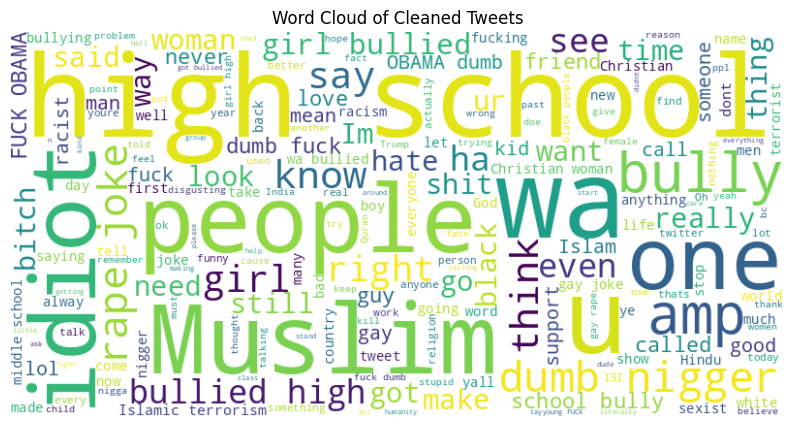

In [ ]:
# Combining all cleaned tweets into a single string
all_tweets = ' '.join(dataset['cleaned_tweet_text'])

# Generating word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tweets)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Tweets')
plt.show()

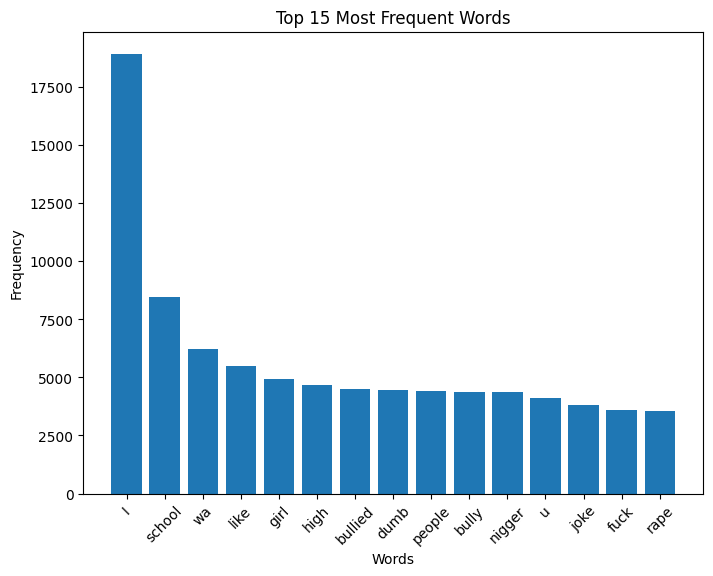

In [ ]:
# Combining all cleaned tweets into a single string
all_tweets = ' '.join(dataset['cleaned_tweet_text'])

# Splitting the cleaned tweet text into words
words = all_tweets.split()

# Counting the frequency of each word
word_counts = Counter(words)

top_n = 15
top_words = dict(word_counts.most_common(top_n))

plt.figure(figsize=(8, 6))
plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Most Frequent Words')
plt.xticks(rotation=45)
plt.show()

### Splitting the dataset

In [ ]:
#Splitting into training and testing data
X = dataset['cleaned_tweet_text']
y = dataset['cyberbullying_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(36064,) (36064,) (9016,) (9016,)


### Logistic Regression

*   **Feature extraction** refers to the process of transforming raw data into numerical features that can be processed while preserving the information in the original data set.

*   TF-IDF (Term Frequency-Inverse Document Frequency) or CountVectorizer is used to transform the text into numerical representations that can be fed into the logistic regression model.

* This vectorizer converts the text data into a matrix representation, where each row corresponds to a document (text sample) and each column corresponds to a unique word (token) in the text.

In [ ]:
vectorizer = TfidfVectorizer()

X_train_tf = vectorizer.fit_transform(X_train)
X_test_tf = vectorizer.transform(X_test)

print(X_train_tf.shape)
print(X_test_tf.shape)

(36064, 39774)
(9016, 39774)


In [ ]:
X_train_array = X_train_tf.toarray()

print(X_train_array[0])

[0. 0. 0. ... 0. 0. 0.]


In [ ]:
lr = LogisticRegression(max_iter=5000)

lr.fit(X_train_tf, y_train)

y_pred = lr.predict(X_test_tf)

In [ ]:
#Accuracy is the ratio of correctly classified instances to the total number of instances.
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8304125998225377


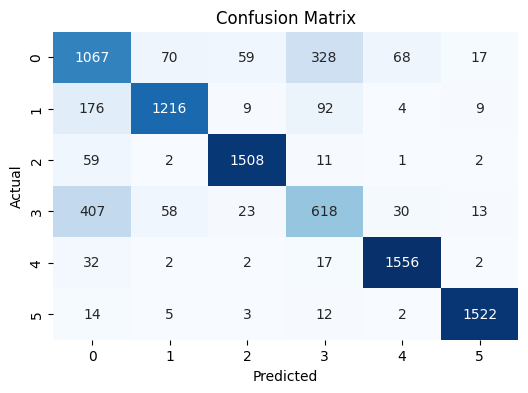

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

* **Accuracy** = number of correctly predicted samples/total number of samples

*   **Precision** = true positives/(true positives + false positives)
*   High precision means when model predicts a positive instance, it is likely to be correct.

*   **Recall** = true positives/(true positives + false negatives)
*   High recall means model can successfully predict a large proportion of positive instances.

*   **F1 Score** = Harmonic mean of precision and recall. It has best value at 1 and worst value at 0.

In [ ]:
# Calculate precision, recall, and F1-score
classification_report = classification_report(y_test, y_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.61      0.66      0.63      1609
           1       0.90      0.81      0.85      1506
           2       0.94      0.95      0.95      1583
           3       0.57      0.54      0.56      1149
           4       0.94      0.97      0.95      1611
           5       0.97      0.98      0.97      1558

    accuracy                           0.83      9016
   macro avg       0.82      0.82      0.82      9016
weighted avg       0.83      0.83      0.83      9016



### Hyperparameter Tuning of Logistic Regression

#### RandomizedSearchCV
* It is a hyperparameter tuning that performs random search over specified hyperparameter combinations.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

* **Hyperparameters**
1. solver: Optimization algorithm used in the logistic regression model.
2. penalty: Regularization term that is to be applied to the logistic regression model.
3. C: Inverse of regularization strength. It controls the amount of regularization applied to the model.
4. max_iter: Maximum number of iterations for the optimization algorithm to converge. If the algorithm does not converge within this number of iterations, it stops even if the optimum is not reached.
5. fit_intercept: Whether to calculate the intercept for the model.

In [ ]:
param_dist = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'C': [100, 10, 1.0, 0.1, 0.01],
    'max_iter': [1500, 2500, 5000],
    'fit_intercept': [True, False]
}

In [ ]:
logreg = LogisticRegression()

* **Parameters of RandomizedSearchCV:**

1. estimator: Machine learning model to be tuned.
2. param_distributions: A dictionary containing the hyperparameter distributions that we want to search over.
3. n_iter: Number of random combinations of hyperparameters that will be tested.
4. cv: Cross-validation parameter. It's set to 5 in this case, meaning a 5-fold cross-validation will be performed.
5. scoring: Metric used to evaluate the performance of the model.
6. n_jobs: The number of CPU cores to use for parallel computation. A value of -1 means using all available cores.

In [ ]:
random_search = RandomizedSearchCV(estimator=logreg, param_distributions=param_dist, n_iter=50, cv=5, scoring='accuracy', n_jobs=-1)

In [ ]:
random_search.fit(X_train_tf, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': [100, 10, 1.0, 0.1, 0.01],
                                        'fit_intercept': [True, False],
                                        'max_iter': [1500, 2500, 5000],
                                        'penalty': ['l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   scoring='accuracy')

In [ ]:
best_parameters = random_search.best_params_
best_lr_model = random_search.best_estimator_

* cv_results_ is a dictionary that stores various results of the cross-validation process performed during the hyperparameter search.

In [ ]:
print(random_search.cv_results_)

{'mean_fit_time': array([ 1.21537161,  1.15715756,  1.64674869,  1.15478158,  2.34224253,
        0.27830009,  1.6798264 , 10.97676725,  1.34597106,  0.84065924,
        5.6057879 ,  0.95586104,  0.60602207,  1.11926136, 17.35960102,
        2.96181564,  5.88250351, 32.44540601,  0.40357442,  4.71783361,
        1.37093272,  1.27124782,  0.79379363,  1.92276111,  1.23022995,
        7.76799655,  3.32243662,  1.35343127,  0.74324527,  1.75795484,
        2.60872173,  2.77483382,  0.67873416,  1.59492502, 33.88659954,
        1.44875884,  1.75617037,  0.95535526,  4.47768397,  1.71218996,
        0.75257916,  1.58209829,  0.64077039,  0.75360975,  1.12879615,
        0.90295367,  3.14407148,  1.21252065,  7.82498698,  2.54657111]), 'std_fit_time': array([0.02736793, 0.07176414, 0.29280283, 0.2785246 , 0.21516163,
       0.00963456, 0.34508228, 1.15116767, 0.47075563, 0.21309884,
       0.50011977, 0.24874412, 0.01666438, 0.09176556, 1.09771885,
       0.713523  , 0.88732536, 1.68589931, 

In [ ]:
print("Best: %f using %s" % (random_search.best_score_, random_search.best_params_))

rs_means= random_search.cv_results_['mean_test_score']
rs_stds = random_search.cv_results_['std_test_score']
rs_params = random_search.cv_results_['params']

for mean, stdev, param in zip(rs_means, rs_stds, rs_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.823092 using {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 5000, 'fit_intercept': True, 'C': 10}
0.810698 (0.002617) with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 5000, 'fit_intercept': False, 'C': 10}
0.809977 (0.005154) with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 1500, 'fit_intercept': False, 'C': 1.0}
0.793894 (0.004905) with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 5000, 'fit_intercept': True, 'C': 0.1}
0.712372 (0.002919) with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 5000, 'fit_intercept': False, 'C': 0.01}
0.819016 (0.004929) with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 2500, 'fit_intercept': True, 'C': 1.0}
0.713981 (0.002833) with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 2500, 'fit_intercept': False, 'C': 0.01}
0.793894 (0.004905) with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 2500, 'fit_intercept': True, 'C': 0.1}
0.819016 (0.004929) with: {'solver': 'lbfgs', 'penalty': 

In [ ]:
best_lr_model.fit(X_train_tf, y_train)

LogisticRegression(C=10, max_iter=5000, solver='liblinear')

In [ ]:
y_predicted_tuned = best_lr_model.predict(X_test_tf)
acc_tuned = accuracy_score(y_test, y_predicted_tuned)
print("Tuned Accuracy:", acc_tuned)

Tuned Accuracy: 0.8332963620230701


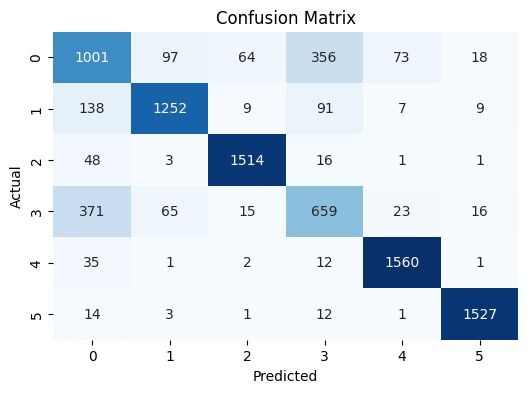

In [ ]:
rs_cm = confusion_matrix(y_test, y_predicted_tuned)
plt.figure(figsize=(6, 4))
sns.heatmap(rs_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### GridSearchCV

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

* RepeatedStratifiedKFold is a cross-validation method that repeatedly performs stratified k-fold cross-validation, where the data is split into k subsets while maintaining the class distribution in each fold.

1. n_splits: The number of folds (subsets) in k-fold cross-validation.

2. n_repeats: The number of times the cross-validation process is repeated.

3. random_state: The random seed used for reproducibility. Setting it to a specific value ensures that the same random splits are used when the code is executed again with the same seed.

In [ ]:
LR = LogisticRegression(max_iter=5000)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
iterations = [1500, 2500, 5000]
intercept = [True, False]

grid = dict(solver=solvers,penalty=penalty,C=c_values,max_iter=iterations,fit_intercept=intercept)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
grid_search = GridSearchCV(estimator=LR, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_tf, y_train)

Took 1h 40m

In [ ]:
grid_result.best_estimator_

LogisticRegression(C=10, max_iter=1500, solver='liblinear')

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.824164 using {'C': 10, 'fit_intercept': True, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear'}
0.801076 (0.006759) with: {'C': 100, 'fit_intercept': True, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'newton-cg'}
0.801094 (0.006738) with: {'C': 100, 'fit_intercept': True, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'lbfgs'}
0.808775 (0.006800) with: {'C': 100, 'fit_intercept': True, 'max_iter': 1500, 'penalty': 'l2', 'solver': 'liblinear'}
0.801076 (0.006759) with: {'C': 100, 'fit_intercept': True, 'max_iter': 2500, 'penalty': 'l2', 'solver': 'newton-cg'}
0.801094 (0.006738) with: {'C': 100, 'fit_intercept': True, 'max_iter': 2500, 'penalty': 'l2', 'solver': 'lbfgs'}
0.808775 (0.006800) with: {'C': 100, 'fit_intercept': True, 'max_iter': 2500, 'penalty': 'l2', 'solver': 'liblinear'}
0.801076 (0.006759) with: {'C': 100, 'fit_intercept': True, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.801094 (0.006738) with: {'C': 100, 'fit_intercept': True, 'max_iter'

In [ ]:
best_params = grid_result.best_params_
best_model = grid_result.best_estimator_

In [ ]:
best_model.fit(X_train_tf, y_train)

LogisticRegression(C=10, max_iter=1500, solver='liblinear')

In [ ]:
y_pred_tuned = best_model.predict(X_test_tf)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print("Tuned Accuracy:", accuracy_tuned)

Tuned Accuracy: 0.8332963620230701


* Improvement from 0.83041 to 0.83329

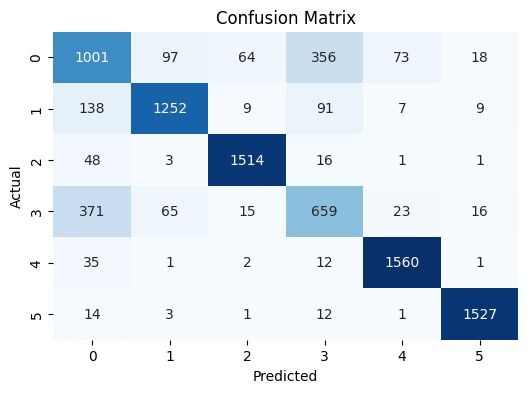

In [ ]:
gs_cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6, 4))
sns.heatmap(gs_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()